## <img src="https://cdn.dal.ca/about-dal/history-tradition/logo-seal/_jcr_content/contentPar/staticimage.adaptive.full.high.png/1654529048363.png" alt="Dalogo" width="200"/>

# CSCI 4144 -  Data Mining and Data Warehousing
# Assignment 1 - Basic Techniques

**Due:** 2 February, 19h AT

**Your name:** \[ENTER YOUR NAME HERE\]  
**Your Banner ID:** \[ENTER YOUR BANNER ID HERE\]  
**Your NetID:** \[ENTER YOUR NETID HERE\]

### Assessment

***!This cell is completed only by your marker!***


| #  | Section       |Mark | Out of  |  Comments |
|----|---------------|-----|---------|-----------|
| 1  | Section 1     |     | /25     |           |
| 2  | Section 2     |     | /22     |           |
| 3  | Bonus         |     | /5      |           |
| -  | TOTAL         |     | /47     |           |

The main purpose of this assignment is to get familiar with processes of constructing and using a data warehouse. There are two sections: the first focuses on simple data loading and cleaning with simple data, and the second focuses on more complex data. In both cases, we will use publicly available datasets focused in the healthcare domain.

In [1]:
# import any libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from fitter import Fitter, get_common_distributions
import requests
import csv

import urllib.request
import xarray as xr
import io
import numpy as np
from io import StringIO


# TODO: add any additional libraries here

# your code should run in Python3.9

## Section 1 - Data cleaning and ETL

A [Notifiable disease](https://en.wikipedia.org/wiki/Notifiable_disease#Canada) is any disease that, by law, must be reported to government authorities. Aggregating data on these diseases allows the authorities to monitor their development, and provides early warning of possible outbreaks. The [Canadian Notifiable Disease Surveillance System](https://diseases.canada.ca/notifiable/) is a searchable database tool provided by the Public Health Agency of Canada. 

In this Section, we will practice cleaning some small, simple datasets.

### Dataset

The data for this section come from [Nova Scotia's Open Data Portal](https://data.novascotia.ca/) under the [Nova Scotia Open Government Licence](http://novascotia.ca/opendata/licence.asp). Specifically:

1. [Notifiable Diseases Counts and Rates By Zone 2014-2017](https://data.novascotia.ca/Health-and-Wellness/Notifiable-Diseases-Counts-and-Rates-By-Zone-2014-/36ek-n7n8), and
2. [Notifiable Diseases Counts and Rates By Sex 2014-2017](https://data.novascotia.ca/Health-and-Wellness/Notifiable-Diseases-Counts-and-Rates-By-Sex-2014-2/hgpa-vixp)

The two files are in the [CSV](https://www.w3schools.com/python/pandas/pandas_csv.asp) file format, with a single header row and the following fields (Zone and Sex only appear in their respective file):

| Field                       | Type      | Description |
|-----------------------------|-----------|-------------|
| Zone                        | Text      | One of four non-overlapping regions, or the aggregate 'Nova Scotia'      |
| Sex                         | Text      | Traditional binary labels, or the aggregate 'All'       |
| Year                        | Int       | The year in the Common Era |
| Disease                     | Text      | The name of the disease. Additional information on the diseases can be found [here](https://novascotia.ca/dhw/cdpc/cdc/). |
| Number of Cases             | Int       | The number of cases in the indicated region, for the indicated year |
| Rate per 100,000 population | Float     | The rate per 100,000 population in the indicated region, for the indicated year |


Public government data are less likely to contain errors that require cleaning or correction, so we have artificially corrupted the data for this assignment using a Python script. Specifically, we have made the following corruptions:

1. **Removal**. We have randomly removed data in individual cells. Fields may be empty, have some indicative label such as 'Null', or some other corruption indicating deletion. To mimic real-world scenarios, we cannot tell you what all of these corruptions may be.
2. **Range errors**. We have given some numeric data impossibly small values.
3. **Spelling**. We have introduced spelling mistakes using the [corrupted-text](https://pypi.org/project/corrupted-text/) library to text fields.
4. **Duplicates**. We have randomly repeated some rows
5. **Shuffle**. We have randomly shuffled rows subsequent to the above corruptions.

### Tasks

Our tasks in this section are to clean the data, perform simple 'sanity checks', and display some simple visualizations. This is essentially a simplified view into an ETL process. You can use the clean data provided directly by the Nova Scotia government at the links above to validate your work, but your code must work assuming you don't have acss to the clean gold standard versions. Also note that we are fortunate that these data have, essentially, error-correcting codes built in, since 'All' data should be the sum of Male and Female data, and 'Nova Scotia' data should be the sum of all the individual regions.

Complete each of the code cells below according to the instructions in the comments.



In [2]:
# 1. load the corrupted data in a Pandas DataFrame. 
#     Note that we will test your code on another corruption of the same dataset, 
#        so you should not hardcode to your version. 
#     Note that you can load your own corruptions for testing, 
#        but you should submit a notebook with our original corruptions.

# Note: you are encouraged to download these files either from here or from Brightspace directly and to use them locally,
#       as long as your code works for the markers (e.g., do not hardcode local paths in submission).
urlSex = 'https://raw.githubusercontent.com/udhaya182/dataset/main/Notifiable_Diseases_Counts_and_Rates_By_Sex_2014-2017.corrupt.csv'
urlZone = 'https://raw.githubusercontent.com/udhaya182/dataset/main/Notifiable_Diseases_Counts_and_Rates_By_Zone_2014-2017.corrupt.csv'

req_sex = urllib.request.Request(urlSex)
req_zone = urllib.request.Request(urlZone)

with urllib.request.urlopen(req_sex) as response_sex:
    # Read the CSV content from the response
    csv_content_sex = response_sex.read().decode('utf-8')

    # Create a DataFrame from the CSV content
    df_sex = pd.read_csv(StringIO(csv_content_sex))
    
with urllib.request.urlopen(req_zone) as response_zone:
    # Read the CSV content from the response
    csv_content_zone = response_zone.read().decode('utf-8')

    # Create a DataFrame from the CSV content
    df_zone = pd.read_csv(StringIO(csv_content_zone))

# Display the first few rows of the DataFrames
print("Sex DataFrame:")
print(df_sex.head())

print("\nZone DataFrame:")
print(df_zone.head())




Sex DataFrame:
   Unnamed: 0     Sex    Year                 Disease  Number of Cases  \
0           0  Female  2014.0  Listeriosis - Invasive              3.0   
1           1     All  2017.0           Salmonellosis            171.0   
2           2    Male  2014.0                 Typhoid              0.0   
3           3    Male  2015.0            Tuberculosis              5.0   
4           4     All  2014.0                 Rubella              0.0   

   Rate per 100,000 population  
0                          0.6  
1                         17.9  
2                          0.0  
3                          1.1  
4                          0.0  

Zone DataFrame:
   Unnamed: 0         Zone    Year                              Disease  \
0           0     Northern  2014.0                              Malaria   
1           1      Western  2017.0  Creutzfeldt-Jakob Disease - Classic   
2           2  Nova Scotia  2014.0               Listeriosis - Invasive   
3           3     Norther

In [3]:
# 2. sort both DataFrames by Year, then by Disease, then by either Zone or Sex. 
#    I.e., all data for 2014 comes before all data from 2015; 
#          within 2014, all data for 'Acquired Immune Deficiency Syndrome' comes before all data for 'Hepatitis B - Acute', 
#          and so on 

# TODO YOUR CODE GOES HERE
# Sort DataFrame by Year, Disease, and Sex
# Sort DataFrame by Year, Disease, and Sex
df_sex_sorted = df_sex.sort_values(by=['Year', 'Disease', 'Sex'], ascending=[True, True, True])

# Display the sorted DataFrame
print("Sorted DataFrame by Sex:")
print(df_sex_sorted.head())
# Sort DataFrame by Year, Disease, and Zone
df_zone_sorted = df_zone.sort_values(by=['Year', 'Disease', 'Zone'], ascending=[True, True, True])

# Display the sorted DataFrame
print("Sorted DataFrame by Zone:")
print(df_zone_sorted.head())


# TODO: print the two sorted Pandas DataFrames

Sorted DataFrame by Sex:
     Unnamed: 0     Sex    Year                              Disease  \
275         275     All  2014.0  Acquired Immune Deficiency Syndrome   
98           98  Female  2014.0  Acquired Immune Deficiency Syndrome   
446         446    Male  2014.0  Acquired Immune Deficiency Syndrome   
215         215     All  2014.0              Acute Flaccid Paralysis   
492         492  Female  2014.0              Acute Flaccid Paralysis   

     Number of Cases  Rate per 100,000 population  
275              2.0                          0.2  
98               0.0                          0.0  
446              2.0                          0.4  
215              1.0                          0.1  
492              1.0                          0.2  
Sorted DataFrame by Zone:
     Unnamed: 0         Zone    Year                              Disease  \
500         500      Central  2014.0  Acquired Immune Deficiency Syndrome   
181         181      Eastern  2014.0  Acquired Imm

In [4]:

# 3. identify duplicate entries

# Identify and print indices of duplicate rows in the 'Sex' DataFrame
duplicate_indices_sex = df_sex[df_sex.duplicated(subset=['Sex', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'])].index.tolist()
print("Duplicate indices in Sex DataFrame:", duplicate_indices_sex)

# Identify and print indices of duplicate rows in the 'Zone' DataFrame
duplicate_indices_zone = df_zone[df_zone.duplicated(subset=['Zone', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'])].index.tolist()
print("Duplicate indices in Zone DataFrame:", duplicate_indices_zone)

# Remove duplicate rows from the 'Sex' DataFrame
df_sex = df_sex.drop_duplicates(subset=['Sex', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'])

# Remove duplicate rows from the 'Zone' DataFrame
df_zone = df_zone.drop_duplicates(subset=['Zone', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'])

# Display the first few rows of the cleaned DataFrames
print("\nCleaned Sex DataFrame:")
print(df_sex.head())

print("\nCleaned Zone DataFrame:")
print(df_zone.head())


Duplicate indices in Sex DataFrame: [190, 207, 235]
Duplicate indices in Zone DataFrame: [343, 369, 576, 609, 620, 801]

Cleaned Sex DataFrame:
   Unnamed: 0     Sex    Year                 Disease  Number of Cases  \
0           0  Female  2014.0  Listeriosis - Invasive              3.0   
1           1     All  2017.0           Salmonellosis            171.0   
2           2    Male  2014.0                 Typhoid              0.0   
3           3    Male  2015.0            Tuberculosis              5.0   
4           4     All  2014.0                 Rubella              0.0   

   Rate per 100,000 population  
0                          0.6  
1                         17.9  
2                          0.0  
3                          1.1  
4                          0.0  

Cleaned Zone DataFrame:
   Unnamed: 0         Zone    Year                              Disease  \
0           0     Northern  2014.0                              Malaria   
1           1      Western  2017.0  Cr

In [5]:
data_types_sex = df_sex.dtypes

# Print the data types
print("Data types in Sex DataFrame:")
print(data_types_sex)

# Similarly, you can do the same for the 'Zone' DataFrame
data_types_zone = df_zone.dtypes

# Print the data types
print("\nData types in Zone DataFrame:")
print(data_types_zone)

Data types in Sex DataFrame:
Unnamed: 0                       int64
Sex                             object
Year                           float64
Disease                         object
Number of Cases                float64
Rate per 100,000 population    float64
dtype: object

Data types in Zone DataFrame:
Unnamed: 0                       int64
Zone                            object
Year                           float64
Disease                         object
Number of Cases                float64
Rate per 100,000 population    float64
dtype: object


In [6]:
missing_values_after_replace_sex = df_sex.isnull().sum().sum()
print("Number of missing values in Sex DataFrame after replacement:", missing_values_after_replace_sex)

# Check for missing values in the 'Zone' DataFrame after replacement
missing_values_after_replace_zone = df_zone.isnull().sum().sum()
print("Number of missing values in Zone DataFrame after replacement:", missing_values_after_replace_zone)

Number of missing values in Sex DataFrame after replacement: 27
Number of missing values in Zone DataFrame after replacement: 45


In [7]:
# 4. identify cells with missing data

# TODO YOUR CODE GOES HERE
# TODO: print a list of indices for the corrupted cells. 
#        E.g., if cells [9, 3] and [20, 1] are missing or have null-like labels, print [[9,3],[20,1]]

# TODO: replace these elements with np.nan



# Identify cells with missing data in the 'Sex' DataFrame
missing_cells_sex = df_sex[df_sex.isnull().any(axis=1)].stack().index.tolist()
print("Indices of cells with missing data in Sex DataFrame:")
print(missing_cells_sex)

# Replace missing elements with np.nan in the 'Sex' DataFrame
df_sex.replace(np.nan, inplace=True)

# Identify cells with missing data in the 'Zone' DataFrame
missing_cells_zone = df_zone[df_zone.isnull().any(axis=1)].stack().index.tolist()
print("\nIndices of cells with missing data in Zone DataFrame:")
print(missing_cells_zone)

# Replace missing elements with np.nan in the 'Zone' DataFrame
df_zone.replace(np.nan, inplace=True)

Indices of cells with missing data in Sex DataFrame:
[(30, 'Unnamed: 0'), (30, 'Sex'), (30, 'Disease'), (30, 'Number of Cases'), (30, 'Rate per 100,000 population'), (67, 'Unnamed: 0'), (67, 'Sex'), (67, 'Year'), (67, 'Number of Cases'), (67, 'Rate per 100,000 population'), (117, 'Unnamed: 0'), (117, 'Sex'), (117, 'Disease'), (117, 'Number of Cases'), (117, 'Rate per 100,000 population'), (125, 'Unnamed: 0'), (125, 'Year'), (125, 'Disease'), (125, 'Number of Cases'), (125, 'Rate per 100,000 population'), (150, 'Unnamed: 0'), (150, 'Sex'), (150, 'Year'), (150, 'Disease'), (150, 'Number of Cases'), (164, 'Unnamed: 0'), (164, 'Sex'), (164, 'Year'), (164, 'Disease'), (164, 'Number of Cases'), (169, 'Unnamed: 0'), (169, 'Sex'), (169, 'Year'), (169, 'Disease'), (169, 'Rate per 100,000 population'), (170, 'Unnamed: 0'), (170, 'Year'), (170, 'Disease'), (170, 'Number of Cases'), (170, 'Rate per 100,000 population'), (173, 'Unnamed: 0'), (173, 'Year'), (173, 'Disease'), (173, 'Number of Cases')

In [8]:
missing_values_after_replace_sex = df_sex.isnull().sum().sum()
print("Number of missing values in Sex DataFrame after replacement:", missing_values_after_replace_sex)

# Check for missing values in the 'Zone' DataFrame after replacement
missing_values_after_replace_zone = df_zone.isnull().sum().sum()
print("Number of missing values in Zone DataFrame after replacement:", missing_values_after_replace_zone)

Number of missing values in Sex DataFrame after replacement: 0
Number of missing values in Zone DataFrame after replacement: 0


In [9]:
# 5. identify cells with out-of-bounds errors

# TODO YOUR CODE GOES HERE
# 5. identify cells with out-of-bounds errors


expected_ranges = {
    'Rate per 100,000 population': (0, np.inf),
    'Number of Cases': (0, np.inf)  
}

# Initialize empty lists to store indices of out-of-bounds cells
out_of_bounds_cells_sex = []
out_of_bounds_cells_zone = []

# Check for out-of-bounds errors in 'Sex' DataFrame
for column, (lower_bound, upper_bound) in expected_ranges.items():
    out_of_bounds_indices = df_sex[(df_sex[column] < lower_bound) | (df_sex[column] > upper_bound)].index.tolist()
    out_of_bounds_cells_sex.extend([(index, column) for index in out_of_bounds_indices])

# Check for out-of-bounds errors in 'Zone' DataFrame
for column, (lower_bound, upper_bound) in expected_ranges.items():
    out_of_bounds_indices = df_zone[(df_zone[column] < lower_bound) | (df_zone[column] > upper_bound)].index.tolist()
    out_of_bounds_cells_zone.extend([(index, column) for index in out_of_bounds_indices])

# Print indices of cells with out-of-bounds errors
print("Indices of cells with out-of-bounds errors in Sex DataFrame:")
print(out_of_bounds_cells_sex)

# Print indices of cells with out-of-bounds errors in Zone DataFrame:
print("\nIndices of cells with out-of-bounds errors in Zone DataFrame:")
print(out_of_bounds_cells_zone)

# Replace out-of-bounds elements with np.nan in the 'Sex' DataFrame
for index, column in out_of_bounds_cells_sex:
    df_sex.loc[index, column] = np.nan

# Replace out-of-bounds elements with np.nan in the 'Zone' DataFrame
for index, column in out_of_bounds_cells_zone:
    df_zone.loc[index, column] = np.nan

# Display the first few rows of the cleaned DataFrames
print("\nCleaned Sex DataFrame:")
print(df_sex.head())

print("\nCleaned Zone DataFrame:")
print(df_zone.head())

# TODO: print a list of indices for the corrupted cells. 
#        E.g., if cells [9, 3] and [20, 1] have out-of-bounds data, print [[9,3],[20,1]]

# TODO: replace these elements with np.nan

Indices of cells with out-of-bounds errors in Sex DataFrame:
[(81, 'Rate per 100,000 population'), (332, 'Rate per 100,000 population'), (483, 'Number of Cases')]

Indices of cells with out-of-bounds errors in Zone DataFrame:
[(364, 'Rate per 100,000 population'), (876, 'Rate per 100,000 population'), (506, 'Number of Cases')]

Cleaned Sex DataFrame:
   Unnamed: 0     Sex    Year                 Disease  Number of Cases  \
0           0  Female  2014.0  Listeriosis - Invasive              3.0   
1           1     All  2017.0           Salmonellosis            171.0   
2           2    Male  2014.0                 Typhoid              0.0   
3           3    Male  2015.0            Tuberculosis              5.0   
4           4     All  2014.0                 Rubella              0.0   

   Rate per 100,000 population  
0                          0.6  
1                         17.9  
2                          0.0  
3                          1.1  
4                          0.0  

Cle

In [10]:
df_zone['Zone'] = df_zone['Zone'].replace({'zastern': 'Eastern', 'Westfrn': 'Western', 'Npva Scotua': 'Nova Scotia'})

# Replace typos in 'Sex' column
df_sex['Sex'] = df_sex['Sex'].replace({'Als': 'All', 'Fepale': 'Female'})
Zone = df_zone['Zone'].unique()
print(Zone)
Sex =  df_sex['Sex'].unique()
print(Sex)

['Northern' 'Western' 'Nova Scotia' 'Eastern' 'Central']
['Female' 'All' 'Male']


In [11]:
# 6. perform additional internal 'sanity check' within each data set
#    For each year, the total reported number of each disease (i.e., in the 'All' or 'Nova Scotia' rows)
#    should be the sum of the component parts.

# TODO: make a list of all unique disease names
diseaseNames = df_sex['Disease'].unique()
diseaseNamesZ = df_zone['Disease'].unique()

# TODO: your code goes here

for year in range(2014, 2018):
    for dataType in ['Sex', 'Zone']:
        for diseaseName in diseaseNames if dataType == 'Sex' else diseaseNamesZ:
            filtered_data = df_sex[(df_sex['Year'] == year) & (df_sex[dataType] == 'All') & (df_sex['Disease'] == diseaseName)] if dataType == 'Sex' else df_zone[(df_zone['Year'] == year) & (df_zone[dataType] == 'Nova Scotia') & (df_zone['Disease'] == diseaseName)]
            
            if not filtered_data.empty:
                # Calculate the sum of 'Male' and 'Female' components
                component_sum = df_sex[(df_sex['Year'] == year) & (df_sex[dataType].isin(['Male', 'Female'])) & (df_sex['Disease'] == diseaseName)]['Number of Cases'].sum() if dataType == 'Sex' else df_zone[(df_zone['Year'] == year) & (df_zone[dataType].isin(['Western', 'Eastern','Northern', 'Central'])) & (df_zone['Disease'] == diseaseName)]['Number of Cases'].sum()
                
                if not np.isclose(filtered_data['Number of Cases'].values[0], component_sum):
                    print(f"{year} {diseaseName} does not sum correctly for {dataType} DataFrame!")


2014 Pertussis does not sum correctly for Sex DataFrame!
2014 Chlamydia does not sum correctly for Sex DataFrame!
2014 Human Immunodeficiency Virus does not sum correctly for Sex DataFrame!
2014 Salmonellosis does not sum correctly for Zone DataFrame!
2014 Syphilis - Non-Infectious or Stage Pending does not sum correctly for Zone DataFrame!
2014 Meningococcal Disease Invasive does not sum correctly for Zone DataFrame!
2014 Typhoid does not sum correctly for Zone DataFrame!
2015 Chlamydia does not sum correctly for Sex DataFrame!
2015 Meningococcal Disease Invasive does not sum correctly for Sex DataFrame!
2015 Human Immunodeficiency Virus does not sum correctly for Sex DataFrame!
2015 Botulism does not sum correctly for Zone DataFrame!
2015 Tetanus does not sum correctly for Zone DataFrame!
2015 Methicillin Resistant Staphylococcus Aureus (MRSA) does not sum correctly for Zone DataFrame!
2015 Pneumococcal Disease Invasive does not sum correctly for Zone DataFrame!
2015 Meningococcal Di

In [12]:
# 7. perform additional external 'sanity check' across both data sets
#    For each year, the total number of each disease should be the same in each dataset 
#    (i.e., the 'All' Sex rows should match the 'Nova Scotia' Zone rows)

# TODO: make a list of all unique disease names
diseaseNames = df_sex['Disease'].unique()

# TODO: your code goes here

for year in range(2014, 2018):
    for diseaseName in diseaseNames:
        # Extract rows for 'All' Sex in Sex DataFrame
        sex_all_rows = df_sex[(df_sex['Year'] == year) & (df_sex['Sex'] == 'All') & (df_sex['Disease'] == diseaseName)]

        # Extract rows for 'Nova Scotia' Zone in Zone DataFrame
        zone_ns_rows = df_zone[(df_zone['Year'] == year) & (df_zone['Zone'] == 'Nova Scotia') & (df_zone['Disease'] == diseaseName)]

        # Check if the reported total number of cases is not the same across datasets
        if not np.isclose(sex_all_rows['Number of Cases'].sum(), zone_ns_rows['Number of Cases'].sum()):
            print(f"{year} {diseaseName} does not match across datasets!")


2014 Pertussis does not match across datasets!
2014 Mumps does not match across datasets!
2014 Syphilis - Non-Infectious or Stage Pending does not match across datasets!
2014 Vancomycin Resistant Enterococcus does not match across datasets!
2014 Methicillin Resistant Staphylococcus Aureus does not match across datasets!
2014 Verotoxigenic E.coli does not match across datasets!
2015 Vancomycin Resistant Enterococcus does not match across datasets!
2015 Methicillin Resistant Staphylococcus Aureus does not match across datasets!
2015 Verotoxigenic E.coli does not match across datasets!
2016 Typhoid does not match across datasets!
2016 Legionellosis does not match across datasets!
2016 Hepatitis A does not match across datasets!
2016 Vancomycin Resistant Enterococcus does not match across datasets!
2016 Group A Streptococcal Disease Invasive -> non-Severe does not match across datasets!
2016 Methicillin Resistant Staphylococcus Aureus does not match across datasets!
2016 Verotoxigenic E.co

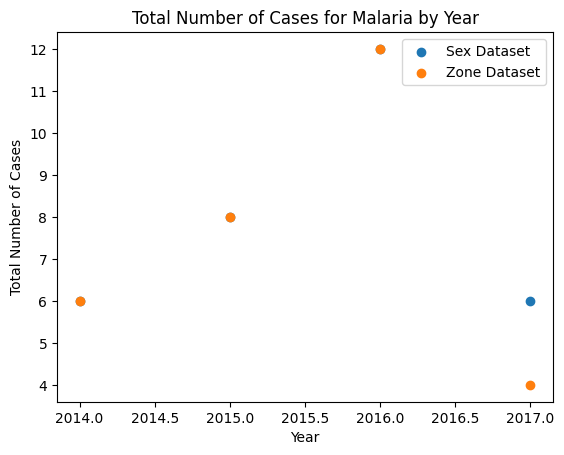

In [13]:
# 8. plot the total number of cases for each year, for the disease indicated in 'diseaseName'
#    Use the matplotlib scatter function (https://matplotlib.org/stable/plot_types/basic/scatter_plot.html)

# Specify the disease name for plotting
diseaseName = 'Malaria'  # no disease name was given, so chose a random one

# Filter rows for the specified disease in df_sex
filtered_rows_sex = df_sex[df_sex['Disease'] == diseaseName]

# Filter rows for the specified disease in df_zone
filtered_rows_zone = df_zone[df_zone['Disease'] == diseaseName]

# Group by Year and sum the Number of Cases for each year in df_sex
total_cases_sex = filtered_rows_sex.groupby('Year')['Number of Cases'].sum()

# Group by Year and sum the Number of Cases for each year in df_zone
total_cases_zone = filtered_rows_zone.groupby('Year')['Number of Cases'].sum()

# Check if the disease is present in the datasets
if not total_cases_sex.empty and not total_cases_zone.empty:
    # Plotting
    plt.scatter(total_cases_sex.index, total_cases_sex, label='Sex Dataset')
    plt.scatter(total_cases_zone.index, total_cases_zone, label='Zone Dataset')

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Total Number of Cases')
    plt.title(f'Total Number of Cases for {diseaseName} by Year')
    plt.legend()
    
    # Show the plot
    plt.show()
else:
    print(f"The specified disease '{diseaseName}' is not present in one or both datasets.")

    

### Assessment for section 1

***!This cell is completed only by your marker!***


| #  | Task          |Mark | Out of  |  Comments |
|----|---------------|-----|---------|-----------|
| 1  | Load          |     | /2      |           |
| 2  | Sort          |     | /5      |           |
| 3  | Duplicates    |     | /3      |           |
| 4  | Missing       |     | /5      |           |
| 5  | Out-of-bounds |     | /2      |           |
| 6  | Intra check   |     | /3      |           |
| 7  | Inter check   |     | /3      |           |
| 8  | Plot          |     | /2      |           |
| -  | TOTAL         |     | /25     |           |


## Section 2 - Data imputation, reduction, and basic analysis

The novel coronavirus disease 2019 ([COVID-19](https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html)) is a contagious disease caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The first known case was identified in December 2019. The disease quickly spread worldwide, resulting in the COVID-19 pandemic. 

In this Section, we will use some simple data science techniques to 1) identify similarities between countries, 2) identify covariates that relate to 

### Dataset: Our World in Data COVID 

The data for this section come [Our World in Data](https://ourworldindata.org/coronavirus), i.e., from their GitHub [repository](https://github.com/owid/covid-19-data/tree/master/public/data). More specifically, the that team aggregated data from multiple sources such as [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19), various official national sources, the United Nations, the World Bank, Global Burden of Disease, and others. It is released under the [Creative Commons BY License](https://creativecommons.org/licenses/by/4.0/).

There are 67 features in the dataset, only some of which we will use. For information on these, consult https://github.com/owid/covid-19-data/tree/master/public/data.

### Tasks

Our task is to look for simple patterns in the COVID data. First, we will 'fill in the blanks' in the data through imputation, project the data down into fewer dimensions, perform some simple distribution fitting to the data, compute measures of entropy, and finally look for features that are highly related or informative.

Complete each of the code cells below according to the instructions in the comments.

In [14]:
# 1. Impute mising data
#    - Select only countries with a population >= 30 million
#    - Use the KNNImputer from scikit-learn, with k=3 nearest neighbours, to impute missing
#      numeric data among the selected countries
#    - Your resulting DataFrame should have all text and numeric fields below

# Note: you are encouraged to download this file either from here or from Brightspace directly and to use it locally,
#       as long as your code works for the markers (e.g., do not hardcode local paths in submission).

from sklearn.impute import KNNImputer

# URL for the COVID dataset
urlCOVID = 'https://dal.brightspace.com/d2l/le/dropbox/250788/174362/DownloadAttachment?fid=14594172'
file_path = 'owid-covid-data.csv'

# Text and numeric fields
text_fields = ['location', 'date']
numeric_fields = ['new_cases_per_million', 'new_deaths_per_million',
                  'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
                  'stringency_index', 'population_density', 'median_age',
                  'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
                  'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                  'population']

# Step 1: Download the dataset
df_covid = pd.read_csv(file_path)

# Step 2: Select countries with population >= 30 million using .copy()
selected_countries = df_covid[df_covid['population'] >= 30000000].copy()

# Step 3: Impute missing numeric data using KNNImputer
imputer = KNNImputer(n_neighbors=3)
selected_countries[numeric_fields] = imputer.fit_transform(selected_countries[numeric_fields])

# Step 4: Create a new DataFrame with text and numeric fields
result_df = selected_countries[text_fields + numeric_fields]

# Display the resulting DataFrame
print(result_df.head())


      location        date  new_cases_per_million  new_deaths_per_million  \
0  Afghanistan  2020-02-24                  0.122                     0.0   
1  Afghanistan  2020-02-25                  0.000                     0.0   
2  Afghanistan  2020-02-26                  0.000                     0.0   
3  Afghanistan  2020-02-27                  0.000                     0.0   
4  Afghanistan  2020-02-28                  0.000                     0.0   

   people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  \
0                      13.043333                            11.463333   
1                      13.043333                            11.463333   
2                      13.043333                            11.463333   
3                      13.043333                            11.463333   
4                      13.043333                            11.463333   

   stringency_index  population_density  median_age  gdp_per_capita  \
0              8.33        

In [15]:
# 2. Extract the top 10 principal components

# TODO: your code goes here
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Extract only the numeric fields
numeric_data = result_df[numeric_fields]

# Standardize the data (important for PCA)
scaler = StandardScaler()
numeric_data_standardized = scaler.fit_transform(numeric_data)

# Apply PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(numeric_data_standardized)

# Create a DataFrame with the top 10 principal components
columns = [f'PC{i+1}' for i in range(10)]
principal_components_df = pd.DataFrame(data=principal_components, columns=columns)

# Display the resulting DataFrame with top 10 principal components
print(principal_components_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.341561 -1.129872  0.449867 -1.182968 -0.690321  1.966477  0.854214   
1 -3.341620 -1.129863  0.449721 -1.183125 -0.690393  1.966439  0.854039   
2 -3.341620 -1.129863  0.449721 -1.183125 -0.690393  1.966439  0.854039   
3 -3.341620 -1.129863  0.449721 -1.183125 -0.690393  1.966439  0.854039   
4 -3.341620 -1.129863  0.449721 -1.183125 -0.690393  1.966439  0.854039   

        PC8       PC9      PC10  
0 -0.524931  1.215569  0.038610  
1 -0.524748  1.215630  0.038611  
2 -0.524748  1.215630  0.038611  
3 -0.524748  1.215630  0.038611  
4 -0.524748  1.215630  0.038611  


2024-02-05 16:10:35.292 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.2e-05)
2024-02-05 16:10:35.294 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=3e-06)
2024-02-05 16:10:35.313 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=4.4e-05)
2024-02-05 16:10:35.348 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2.8e-05)
2024-02-05 16:10:35.517 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=3.1e-05)
2024-02-05 16:10:36.243 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-02-05 16:10:36.348 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=4.5e-05)
2024-02-05 16:10:36.426 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitte

Summary for new_cases_per_million:
          sumsquare_error           aic           bic  kl_div  ks_statistic  \
expon            0.000003  11490.832025  11508.982912     inf      0.402142   
chi2             0.000022   3392.871639   3420.097969     inf      0.527739   
exponpow         0.000027   2194.106142   2221.332472     inf      0.302893   
rayleigh         0.000028  36075.336590  36093.487477     inf      0.356465   
cauchy           0.000031   3104.466392   3122.617279     inf      0.364048   

          ks_pvalue  
expon           0.0  
chi2            0.0  
exponpow        0.0  
rayleigh        0.0  
cauchy          0.0  


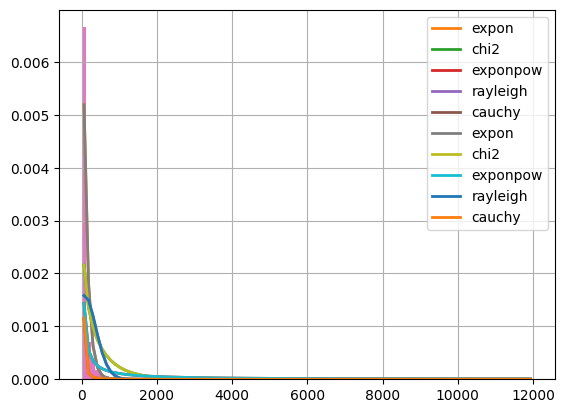

2024-02-05 16:10:37.304 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.139105)
2024-02-05 16:10:37.323 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.637336)
2024-02-05 16:10:37.360 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.892999)
2024-02-05 16:10:37.373 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.56861)
2024-02-05 16:10:37.520 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.220002)
2024-02-05 16:10:38.465 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-02-05 16:10:38.599 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.28765)
2024-02-05 16:10:38.654 | INFO     | fitter.fitter:_fit_single_distribution:337 -

Summary for new_deaths_per_million:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon            0.139105  6529.334176  6547.485062     inf      0.352055   
cauchy           0.220002  1903.192862  1921.343748     inf      0.362391   
gamma            0.287650  5567.233708  5594.460037     inf      0.236068   
chi2             0.386321  1935.480232  1962.706562     inf      0.395718   
exponpow         0.454678  2194.881868  2222.108198     inf      0.414256   

          ks_pvalue  
expon           0.0  
cauchy          0.0  
gamma           0.0  
chi2            0.0  
exponpow        0.0  


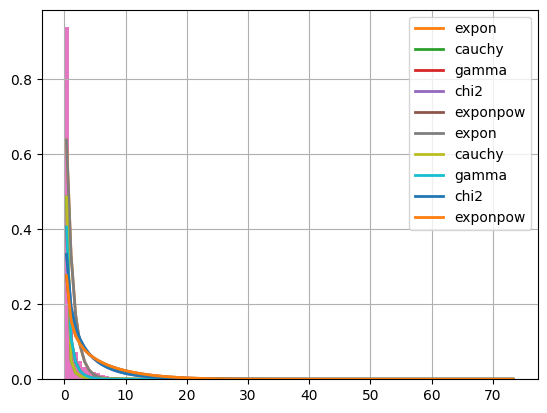

2024-02-05 16:10:39.373 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.016957)
2024-02-05 16:10:39.378 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.023126)
2024-02-05 16:10:39.397 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.019819)
2024-02-05 16:10:39.431 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.022476)
2024-02-05 16:10:39.609 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.024133)
2024-02-05 16:10:40.455 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-02-05 16:10:40.499 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.008983)
2024-02-05 16:10:40.644 | INFO     | fitter.fitter:_fit_single_distribution:337

Summary for people_vaccinated_per_hundred:
          sumsquare_error          aic          bic    kl_div  ks_statistic  \
lognorm          0.007306  1315.736620  1342.962949  0.365155      0.337801   
gamma            0.008983  1006.717766  1033.944095  0.257517      0.175799   
exponpow         0.011463   972.153444   999.379773  0.244437      0.157451   
expon            0.016957   974.499156   992.650043  0.315748      0.145612   
uniform          0.019819   908.401189   926.552075  0.261426      0.215815   

          ks_pvalue  
lognorm         0.0  
gamma           0.0  
exponpow        0.0  
expon           0.0  
uniform         0.0  


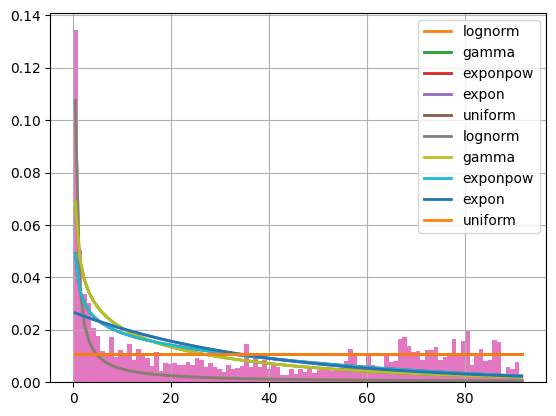

2024-02-05 16:10:41.404 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.03917)
2024-02-05 16:10:41.406 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.02993)
2024-02-05 16:10:41.424 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.036338)
2024-02-05 16:10:41.452 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.038138)
2024-02-05 16:10:41.647 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.038416)
2024-02-05 16:10:42.480 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-02-05 16:10:42.595 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.020415)
2024-02-05 16:10:42.677 | INFO     | fitter.fitter:_fit_single_distribution:337 -

Summary for people_fully_vaccinated_per_hundred:
          sumsquare_error          aic          bic    kl_div  ks_statistic  \
exponpow         0.014577   997.731609  1024.957939  0.205694      0.105108   
lognorm          0.014585  1326.792006  1354.018336  0.294175      0.356973   
gamma            0.020415  1030.817800  1058.044130  0.333142      0.226014   
expon            0.029930   976.673383   994.824269  0.336290      0.162545   
uniform          0.036338   902.512248   920.663135  0.382021      0.270594   

          ks_pvalue  
exponpow        0.0  
lognorm         0.0  
gamma           0.0  
expon           0.0  
uniform         0.0  


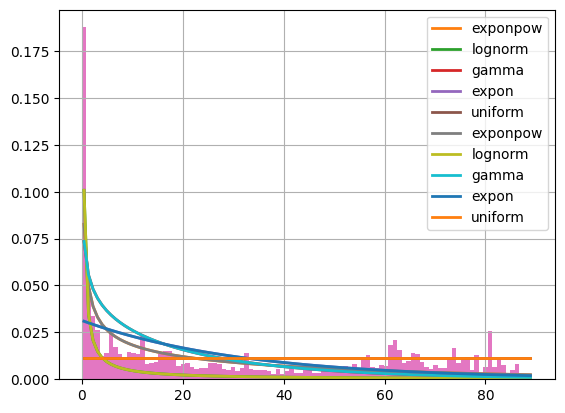

2024-02-05 16:10:43.485 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.004455)
2024-02-05 16:10:43.485 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.009915)
2024-02-05 16:10:43.502 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.006166)
2024-02-05 16:10:43.522 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.005245)
2024-02-05 16:10:43.663 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.005501)
2024-02-05 16:10:44.561 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.00593)
2024-02-05 16:10:44.579 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.004533)
2024-02-05 16:10:44.743 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted c

Summary for stringency_index:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
norm             0.004455   975.855872   994.006758     inf      0.078133   
lognorm          0.004493   978.615497  1005.841827     inf      0.080123   
gamma            0.004533   976.536595  1003.762925     inf      0.077867   
rayleigh         0.005245   962.163152   980.314038     inf      0.117819   
cauchy           0.005501  1028.104309  1046.255195     inf      0.114814   

          ks_pvalue  
norm            0.0  
lognorm         0.0  
gamma           0.0  
rayleigh        0.0  
cauchy          0.0  


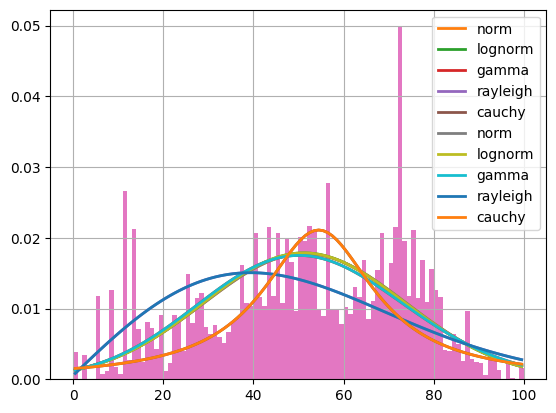

2024-02-05 16:10:45.445 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000243)
2024-02-05 16:10:45.448 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=9.7e-05)
2024-02-05 16:10:45.462 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.000364)
2024-02-05 16:10:45.497 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.000211)
2024-02-05 16:10:45.680 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.000212)
2024-02-05 16:10:45.686 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000142)
2024-02-05 16:10:46.021 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=7.9e-05)
2024-02-05 16:10:46.304 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

Summary for population_density:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm          0.000079  1800.510157  1827.736486     inf      0.058603   
expon            0.000097  1921.368643  1939.519529     inf      0.116412   
chi2             0.000112  1904.490488  1931.716818     inf      0.112091   
gamma            0.000112  1895.787585  1923.013915     inf      0.112150   
exponpow         0.000140  1741.523454  1768.749784     inf      0.204437   

              ks_pvalue  
lognorm   3.434505e-193  
expon      0.000000e+00  
chi2       0.000000e+00  
gamma      0.000000e+00  
exponpow   0.000000e+00  


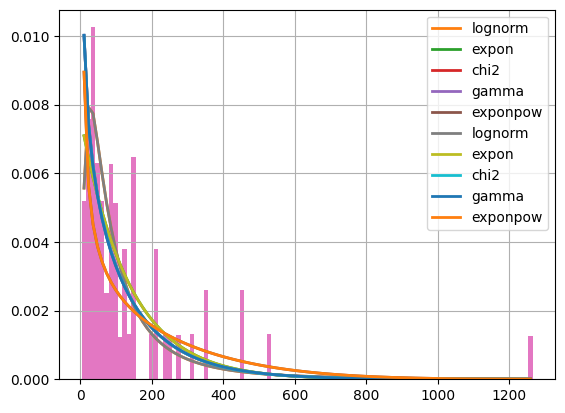

2024-02-05 16:10:46.877 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.329183)
2024-02-05 16:10:46.877 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.312841)
2024-02-05 16:10:46.897 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.309121)
2024-02-05 16:10:46.919 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.314357)
2024-02-05 16:10:47.090 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.318093)
2024-02-05 16:10:47.095 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.325156)
2024-02-05 16:10:47.224 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.312844)
2024-02-05 16:10:47.636 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

Summary for median_age:
         sumsquare_error         aic         bic  kl_div  ks_statistic  \
uniform         0.309121  695.893258  714.044144     inf      0.114765   
norm            0.312841  733.030331  751.181217     inf      0.148214   
gamma           0.312844  735.024955  762.251285     inf      0.148287   
lognorm         0.312964  735.046853  762.273183     inf      0.150266   
chi2            0.313333  735.003872  762.230202     inf      0.153811   

         ks_pvalue  
uniform        0.0  
norm           0.0  
gamma          0.0  
lognorm        0.0  
chi2           0.0  


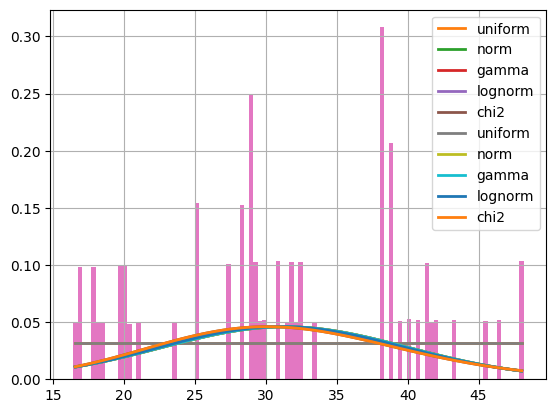

2024-02-05 16:10:48.387 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-02-05 16:10:48.388 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-02-05 16:10:48.410 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2024-02-05 16:10:48.467 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-02-05 16:10:48.645 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-02-05 16:10:48.680 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-02-05 16:10:49.269 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-02-05 16:10:49.295 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2

Summary for gdp_per_capita:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon        1.136808e-07  2258.663471  2276.814357     inf      0.084091   
gamma        1.136938e-07  2274.921444  2302.147774     inf      0.106436   
exponpow     1.142835e-07  2252.663426  2279.889755     inf      0.079136   
powerlaw     1.222556e-07  2233.260337  2260.486666     inf      0.132742   
cauchy       1.250407e-07  2353.186576  2371.337463     inf      0.202735   

          ks_pvalue  
expon           0.0  
gamma           0.0  
exponpow        0.0  
powerlaw        0.0  
cauchy          0.0  


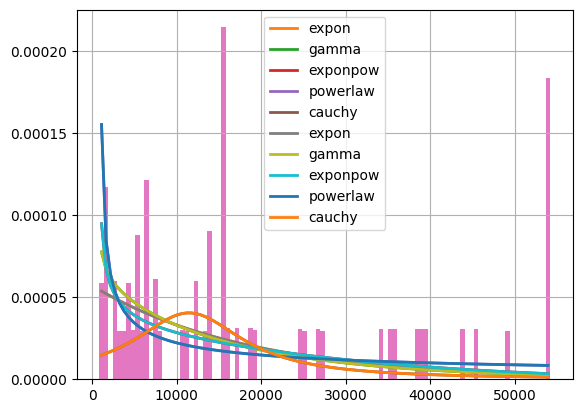

2024-02-05 16:10:50.141 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.149249)
2024-02-05 16:10:50.144 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.229574)
2024-02-05 16:10:50.159 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.247046)
2024-02-05 16:10:50.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.222092)
2024-02-05 16:10:50.344 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.108608)
2024-02-05 16:10:50.355 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.079526)
2024-02-05 16:10:51.014 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.070368)
2024-02-05 16:10:51.071 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

Summary for extreme_poverty:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma            0.070368  1158.446217  1185.672547     inf      0.143692   
chi2             0.078521  1108.676778  1135.903108     inf      0.142701   
cauchy           0.079526  1499.453353  1517.604240     inf      0.309917   
exponpow         0.108276  1029.098626  1056.324956     inf      0.277474   
powerlaw         0.108608  1099.386737  1126.613067     inf      0.303053   

          ks_pvalue  
gamma           0.0  
chi2            0.0  
cauchy          0.0  
exponpow        0.0  
powerlaw        0.0  


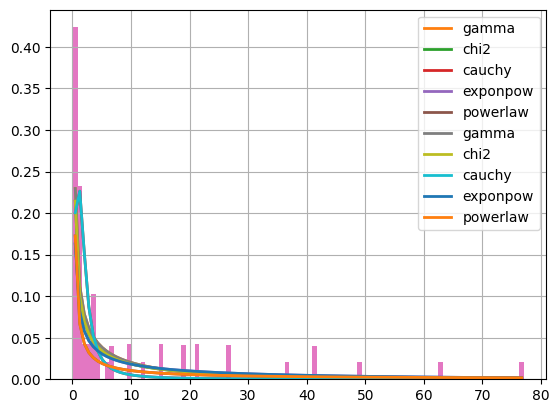

2024-02-05 16:10:51.856 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.000768)
2024-02-05 16:10:51.862 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000761)
2024-02-05 16:10:51.883 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.000902)
2024-02-05 16:10:51.918 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.000735)
2024-02-05 16:10:52.084 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.000892)
2024-02-05 16:10:52.092 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000751)
2024-02-05 16:10:52.187 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000732)
2024-02-05 16:10:52.397 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

Summary for cardiovasc_death_rate:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm          0.000729  1433.776710  1461.003040     inf      0.080267   
gamma            0.000732  1422.482419  1449.708749     inf      0.093317   
chi2             0.000732  1422.482432  1449.708761     inf      0.093318   
exponpow         0.000734  1431.138186  1458.364515     inf      0.125749   
rayleigh         0.000735  1465.280366  1483.431253     inf      0.143411   

          ks_pvalue  
lognorm         0.0  
gamma           0.0  
chi2            0.0  
exponpow        0.0  
rayleigh        0.0  


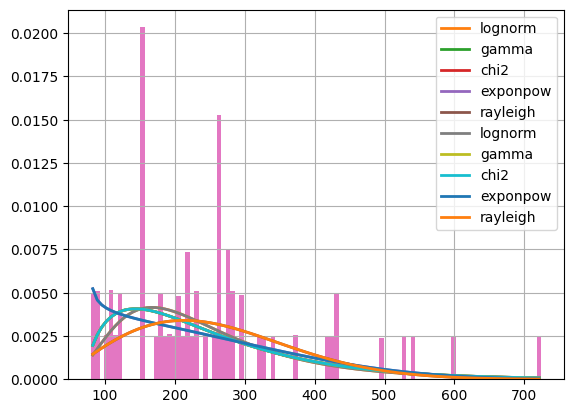

2024-02-05 16:10:53.263 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1.831957)
2024-02-05 16:10:53.265 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2.26694)
2024-02-05 16:10:53.286 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=2.770695)
2024-02-05 16:10:53.307 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2.119049)
2024-02-05 16:10:53.423 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=2.058544)
2024-02-05 16:10:53.464 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=2.562134)
2024-02-05 16:10:53.936 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1.882382)
2024-02-05 16:10:53.994 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted

Summary for hospital_beds_per_thousand:
          sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon            1.831957  694.684067  712.834953     inf      0.124729   
lognorm          1.882382  707.507894  734.734224     inf      0.098575   
cauchy           2.058544  783.108574  801.259460     inf      0.160906   
rayleigh         2.119049  776.619607  794.770493     inf      0.263437   
norm             2.266940  794.473015  812.623901     inf      0.256917   

          ks_pvalue  
expon           0.0  
lognorm         0.0  
cauchy          0.0  
rayleigh        0.0  
norm            0.0  


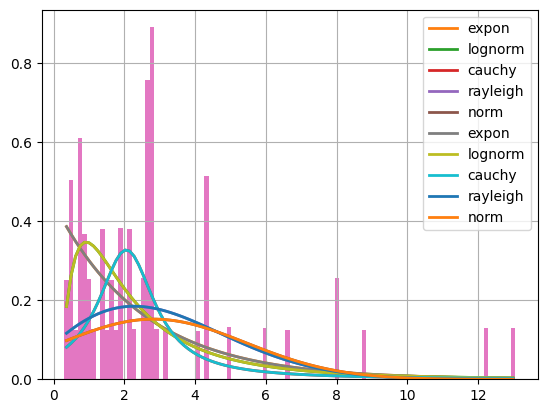

2024-02-05 16:10:54.489 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.388665)
2024-02-05 16:10:54.496 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.472806)
2024-02-05 16:10:54.513 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.415758)
2024-02-05 16:10:54.531 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.409621)
2024-02-05 16:10:54.558 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.393925)
2024-02-05 16:10:54.666 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.390628)
2024-02-05 16:10:55.170 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.389942)
2024-02-05 16:10:55.223 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

Summary for life_expectancy:
         sumsquare_error         aic         bic  kl_div  ks_statistic  \
norm            0.388665  769.187797  787.338684     inf      0.144114   
lognorm         0.389377  774.737706  801.964035     inf      0.146308   
gamma           0.389942  773.148156  800.374486     inf      0.144632   
cauchy          0.390628  821.135966  839.286853     inf      0.160977   
chi2            0.391004  770.017857  797.244187     inf      0.150666   

         ks_pvalue  
norm           0.0  
lognorm        0.0  
gamma          0.0  
cauchy         0.0  
chi2           0.0  


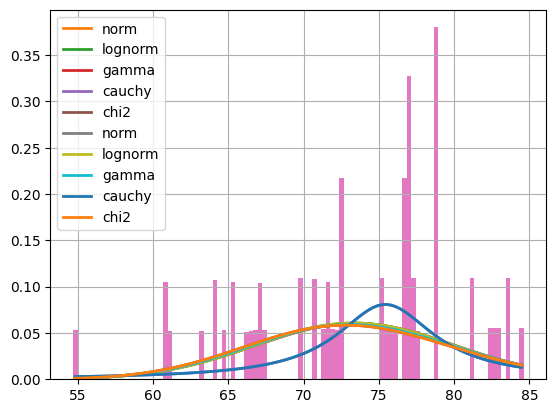

2024-02-05 16:10:56.048 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1253.412616)
2024-02-05 16:10:56.052 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1375.506062)
2024-02-05 16:10:56.071 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=1217.244343)
2024-02-05 16:10:56.096 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1271.340293)
2024-02-05 16:10:56.152 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=1284.41622)
2024-02-05 16:10:56.204 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=1262.902943)
2024-02-05 16:10:56.497 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1243.378965)
2024-02-05 16:10:56.647 | INFO     | fitter.fitter:_fit_single_dis

Summary for human_development_index:
          sumsquare_error         aic         bic  kl_div  ks_statistic  \
uniform       1217.244343 -138.262230 -120.111344     inf      0.172486   
exponpow      1243.378965 -106.881033  -79.654704     inf      0.099080   
norm          1253.412616  -96.685358  -78.534471     inf      0.092554   
lognorm       1254.339283  -94.683939  -67.457609     inf      0.093241   
gamma         1255.734313  -94.686667  -67.460337     inf      0.090147   

          ks_pvalue  
uniform         0.0  
exponpow        0.0  
norm            0.0  
lognorm         0.0  
gamma           0.0  


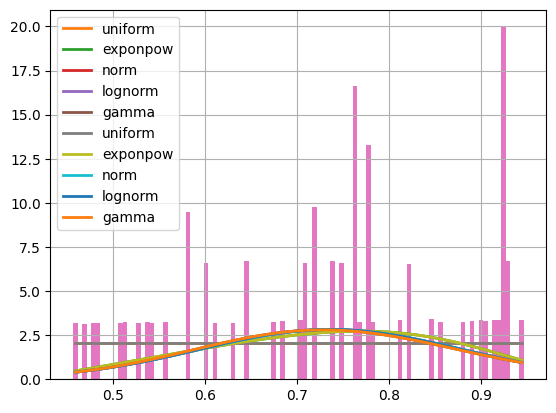

2024-02-05 16:10:57.482 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-02-05 16:10:57.484 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-02-05 16:10:57.501 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2024-02-05 16:10:57.604 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-02-05 16:10:57.780 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-02-05 16:10:57.916 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-02-05 16:10:58.423 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-02-05 16:10:58.471 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2

Summary for population:
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
cauchy       1.392207e-18  5482.350222  5500.501108     inf      0.296739   
lognorm      9.028325e-18  5062.624857  5089.851187     inf      0.075663   
chi2         2.914271e-17  4833.597257  4860.823586     inf      0.259139   
exponpow     3.147853e-17  4782.736004  4809.962333     inf      0.313314   
gamma        3.274633e-17  4763.758738  4790.985068     inf      0.401737   

          ks_pvalue  
cauchy          0.0  
lognorm         0.0  
chi2            0.0  
exponpow        0.0  
gamma           0.0  


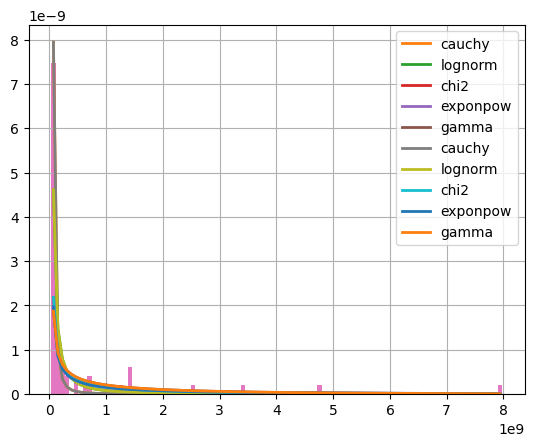

In [16]:
# 3. For each numeric field separately, using the imputed data:
#        a) identify best distributions using the Fitter library 
#           (https://pypi.org/project/fitter/) 
#           Only consider the subset in common_distributions
#        b) print the summary for each fit using the built in fitter summary() function
#        c) plot the data using the Fitter.hist() function
#        d) plot the density function using the Fitter.plot_pdf() function

common_distributions = get_common_distributions()
# TODO: your code goes here
for field in numeric_fields:
    # Extract the column data
    data = result_df[field].dropna()

    # Identify best distributions using Fitter
    f = Fitter(data, distributions=common_distributions)
    f.fit()

    # Print summary for each fit
    print(f"Summary for {field}:")
    print(f.summary())

    # Plot the data
    f.hist()

    # Plot the density function
    f.plot_pdf()

    # Show the plots
    plt.show()

In [17]:
import scipy

# Print the version of SciPy library
print("SciPy version:", scipy.__version__)

SciPy version: 1.10.0


In [18]:
# 4. For each numeric field separately, using the imputed data:
#        a) Using the best distribution from the previous cell, _and all of its parameters_,
#           print the results of the associated entropy() method in scipy.stats
#           e.g., if the best distribution found is chi2, call
#                 scipy.stats.chi2.entropy( mydf, loc=myloc, scale=myscale ) for 
#                 computed values of mydf, myloc, and myscale
#        b) bin the data for that field once into 100 equal-width bins and
#           once into 100 equal-frequency bins. Store the proportional frequency of
#           each bin, relative to the total number of samples, in p_equalWidth and 
#           p_equalFreq, below
#        c) compute and print the Shannon entropy on each of p_equalWidth and p_equalFreq using
#           https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
#
#    In the Markdown cell below, describe in your own words what differences you observe
#    in the results between the distribution-based and the two Shannon-based entropy methods.
#    Which numeric field is the most informative? Which is the least informative?

# TODO: your code goes here

from scipy.stats import entropy
# Placeholder for results
entropy_results = {}

#    discretize data in two methods - equal probability vs equal size.
#    compute entropy.
p_equalWidth = np.zeros(100)
p_equalFreq  = np.zeros(100)

for field in numeric_fields:
    # Extract the best distribution and its parameters from the previous cell
    best_distribution = 'gamma'  # replace with the actual best distribution
    distribution_params = {'a': 2, 'loc': 0, 'scale': 1}  # replace with the actual parameters

    # Compute entropy using the best distribution and its parameters
    data = result_df[field].dropna()
    entropy_value = entropy(data, base=2)
    entropy_results[field] = entropy_value

    # Bin the data into 100 equal-width bins
    bins_equalWidth = np.linspace(min(data), max(data), num=100)
    _, _ = np.histogram(data, bins=bins_equalWidth, density=True)
    p_equalWidth += _ / len(numeric_fields)

    # Bin the data into 100 equal-frequency bins
    _, bins_equalFreq = np.histogram(data, bins=100, density=True)
    p_equalFreq += bins_equalFreq[:-1] / len(numeric_fields)


# Compute Shannon entropy for equal-width and equal-frequency bins
shannon_entropy_equalWidth = entropy(p_equalWidth, base=2)
shannon_entropy_equalFreq = entropy(p_equalFreq, base=2)

# Print results
print("Entropy Results:")
for field, entropy_value in entropy_results.items():
    print(f"{field}: {entropy_value}")

print("\nShannon Entropy - Equal Width Bins:", shannon_entropy_equalWidth)
print("Shannon Entropy - Equal Frequency Bins:", shannon_entropy_equalFreq)


Entropy Results:
new_cases_per_million: 13.741666622404932
new_deaths_per_million: 14.205030444469772
people_vaccinated_per_hundred: 15.365542870607312
people_fully_vaccinated_per_hundred: 15.273172347534205
stringency_index: 15.818209110602325
population_density: 15.203615181889415
median_age: 15.921618289875356
gdp_per_capita: 15.443435229320931
extreme_poverty: 14.507567740168085
cardiovasc_death_rate: 15.799595214222062
hospital_beds_per_thousand: 15.491964951774179
life_expectancy: 15.972528040935842
human_development_index: 15.951046450041519
population: 14.003678550712088

Shannon Entropy - Equal Width Bins: 6.363563280463256
Shannon Entropy - Equal Frequency Bins: 6.363619264704724


**TODO**: Enter your discussion for task 4 of Section 2 here, in no more than 10 sentences.
Distribution based entropy provide insights into the inherent variablilty of each numeric field.
The numeric field with the highest entropy is life_expectancy, indicating a higher degree of variability. 
The numeric field with the lowest entropy is new_cases_per_million, suggesting a more concentrated or predictable pattern in the distribution of new cases per million.
Shannon entropy values in regards to different binning methods provide information on content depending on the methods. 
The Shannon entropy values for both equal-width and equal-frequency bins are quite close. This suggests that the choice of binning method does not significantly impact the overall information content of the data.
In this context I think that the distribution based entropy offers more information on the variability and patterns within each numeric fieldas the shannon entropy values depend on tehe binning methods and they dont have any significant difference. 

/var/folders/_r/83yy5vjs36q62vltgb7yxkn00000gn/T/ipykernel_85331/3714765630.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = result_df.corr()[[outcome]]


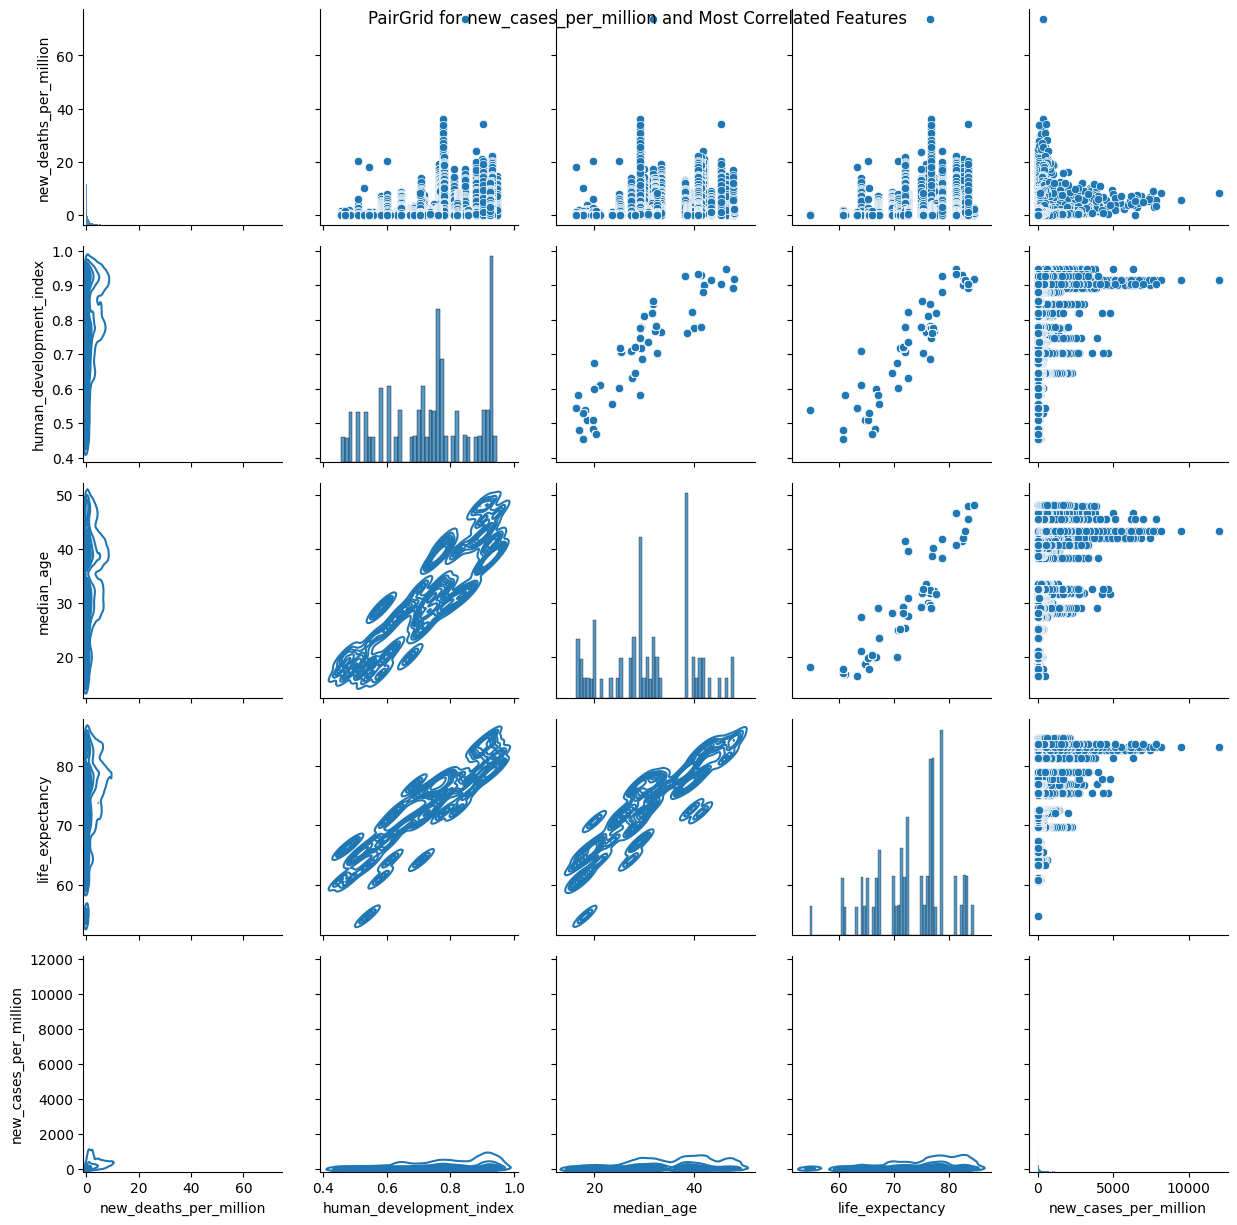

/var/folders/_r/83yy5vjs36q62vltgb7yxkn00000gn/T/ipykernel_85331/3714765630.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = result_df.corr()[[outcome]]


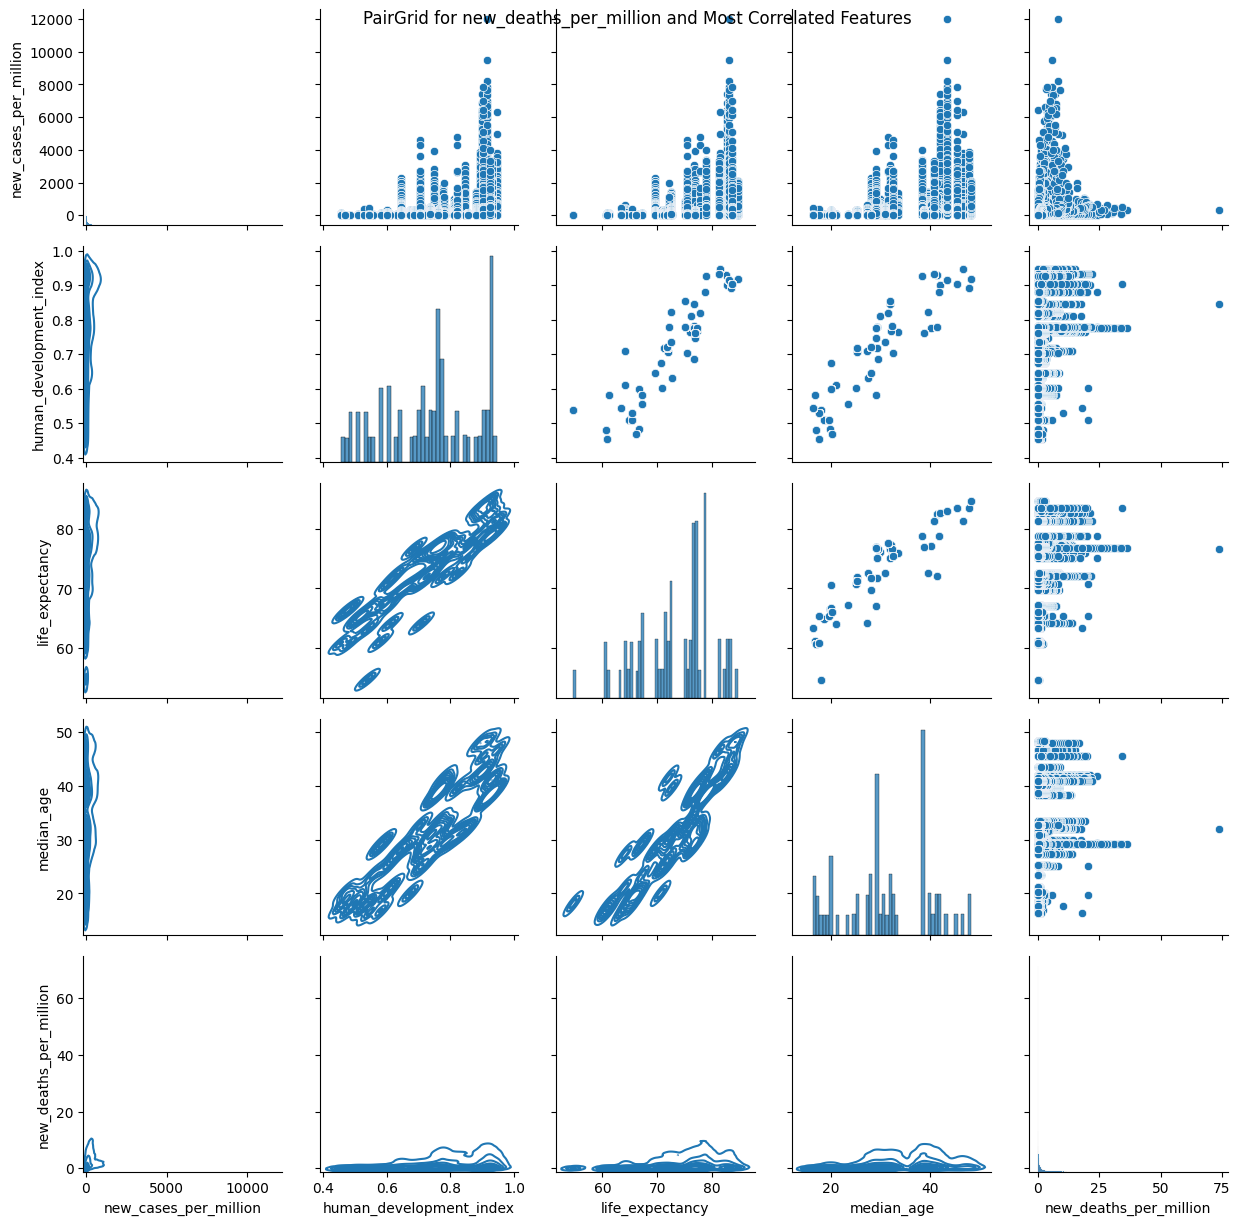

Most Correlated Features for new_cases_per_million: ['new_deaths_per_million', 'human_development_index', 'median_age', 'life_expectancy']
Most Correlated Features for new_deaths_per_million: ['new_cases_per_million', 'human_development_index', 'life_expectancy', 'median_age']


In [19]:
# 5. Identify variables that relate to important COVID outcomes
#    For each of 'new_cases_per_million' and 'new_deaths_per_million', compute Pearson
#    correlation (using https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)
#    with that field and all other numeric fields
#
#        For the 4 features most correlated with the outcome of interest, plot a 5x5 
#        SeaBorn PairGrid (https://seaborn.pydata.org/generated/seaborn.PairGrid.html) with
#        scatter in the upper matrix, histograms on the diagonal, and kde plots on the 
#        lower matrix, as in:
#
#               g = sns.PairGrid(penguins, diag_sharey=False)
#               g.map_upper(sns.scatterplot)
#               g.map_lower(sns.kdeplot)
#               g.map_diag(sns.histplot)
#
#    In the Markdown cell below, list the features that are most correlated with 
#    'new_cases_per_million' and 'new_deaths_per_million'. Are these the same that 
#    were 'informative' in task 4 of Section 2? Why or why not?
#
# TODO: your code goes here
import seaborn as sns

# Define the outcome variables
outcomes = ['new_cases_per_million', 'new_deaths_per_million']

# Placeholder for the most correlated features
most_correlated_features = {}

# Calculate Pearson correlation for each outcome variable
for outcome in outcomes:
    # Calculate correlation with all other numeric fields
    correlation_matrix = result_df.corr()[[outcome]]
    
    # Sort features by absolute correlation
    sorted_features = correlation_matrix.abs().sort_values(by=outcome, ascending=False)
    
    # Select the top 4 most correlated features (excluding the outcome variable itself)
    top_features = sorted_features[1:5].index.tolist()
    
    # Store the most correlated features
    most_correlated_features[outcome] = top_features
    
    # Create a PairGrid for visualization
    g = sns.PairGrid(result_df[top_features + [outcome]], diag_sharey=False)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.histplot)
    g.fig.suptitle(f'PairGrid for {outcome} and Most Correlated Features')
    plt.show()

# Print the most correlated features for each outcome
print("Most Correlated Features for new_cases_per_million:", most_correlated_features['new_cases_per_million'])
print("Most Correlated Features for new_deaths_per_million:", most_correlated_features['new_deaths_per_million'])


**TODO**: Enter your discussion for task 5 of Section 2 here, in no more than 5 sentences.
Correlated features: 
For 'new_cases_per_million':

'new_deaths_per_million'
'human_development_index'
'median_age'
'life_expectancy'
For 'new_deaths_per_million':

'new_cases_per_million'
'human_development_index'
'life_expectancy'
'median_age'

The features most correlated with 'new_cases_per_million' include 'new_deaths_per_million,' which was also identified as informative in Task 4. Other features include 'human_development_index,' 'median_age,' and 'life_expectancy.'

The features most correlated with 'new_deaths_per_million' include 'new_cases_per_million,' which aligns with the informative features in Task 4. Other features include 'human_development_index,' 'life_expectancy,' and 'median_age.'

The overlap suggests that variables such as 'new_deaths_per_million,' 'human_development_index,' 'median_age,' and 'life_expectancy' are consistently influential across different analytical approaches.






### Assessment for section 2

***!This cell is completed only by your marker!***


| #  | Task          |Mark | Out of  |  Comments |
|----|---------------|-----|---------|-----------|
| 1  | Impute        |     | /4      |           |
| 2  | PCA           |     | /1      |           |
| 3  | Fit           |     | /4      |           |
| 4  | Entropy       |     | /8      |           |  
| 5  | Correlations  |     | /5      |           |
| -  | TOTAL         |     | /22     |           |

## Bonus [5 Marks]

- We will give up to 5 bonus marks for innovative work going substantially beyond the minimal requirements. 
- These marks can make up for marks lost in other sections of the assignment, but your overall mark for this assignment cannot exceed 100%. 
- You may decide to pursue any number of tasks of your own design related to this assignment, although you should consult with the instructor or the lead TA before embarking on such exploration, and the value of bonus work is left to the discretion of the markers. 
- Be sure to document your work sufficiently for the markers to understand what you're doing. You can add additional Code or MarkDown cells below, as necessary.
- Certainly, the rest of the assignment takes higher priority. 

Some ideas:

1. **Outlier corruptions**. Introduce some outliers to the data in Section 1, and write a program that can identify and potentially remove those outliers. Experiment with different methods of ourlier detection, compare them, and report your results.
2. **Spelling correction**. Correct the spelling errors in Section 1, or at least identify which text fields have errors in them. 
3. **Imputation**. Perform imputation for the missing Nova Scotia data in Section 1.
4. **Better correlations**. Are there better ways of assessing correlation between variables across time series, in Section 2?
5. **Differential entropy**. Consider reading scientific articles on differential entropy, using the method from scipy.stats.differential_entropy, and comparing against the results you obtained in Section 2. How do you expect the results to differ? How are the results different?
6. **Analysis of principal components**. Repeat some of the analysis you did with the original features (e.g., entropy) but with the principal components you extracted. What do you observe across the principal components? How are the results different than with the original features?
7. **General improvements**. Are there any approaches prescribed in this assignment that would have been more appropriate or meaningful?


In [20]:
# BONUS Section
#i did the spelling correction in the above code for section 1 :)

# TODO YOUR CODE GOES HERE

**TODO**: Any discussion for the Bonus section goes here. Feel free to add additional cells below this one, and before the assessment cell. 

### Assessment for bonus section

***!This cell is completed only by your marker!***


| #  | Task          |Mark | Out of  |  Comments |
|----|---------------|-----|---------|-----------|
| 1  | Bonus         |     | /5      |           |


## Academic Integrity

The following is template information. If there is any ambiguity or contradiction with official Dalhousie University policies, those Dalhousie University policies take effect.

At Dalhousie University, we respect the values of academic integrity: honesty, trust, fairness, responsibility, and respect. As a student, adherence to the values of academic integrity and related policies is a requirement of being part of the academic community at Dalhousie University.

### What does academic integrity mean?

Academic integrity means being honest in the fulfillment of your academic responsibilities thus establishing mutual trust. Fairness is essential to the interactions of the academic community and is achieved through respect for the opinions and ideas of others. Violations of intellectual honesty are oﬀensive to the entire academic community, not just to the individual faculty member and students in whose class an oﬀence occur (See the Dalhousie Secretariat's page on [Academic Integrity](https://www.dal.ca/dept/university_secretariat/academic-integrity.html).

### How can you achieve academic integrity?

- Make sure you understand Dalhousie’s policies on academic integrity.
- Give appropriate credit to the sources used in your assignment such as written or oral work, computer codes/programs, artistic or architectural works, scientific projects,  performances,  web page designs, graphical representations, diagrams, videos, and images. Use [RefWorks](http://www.library.dal.ca/How/RefWorks) to keep track of your research and edit and format bibliographies in the citation style required by the instructor.
- Do not download the work of another from the Internet and submit it as your own.
- Do not submit work that has been completed through collaboration or previously submitted for another assignment without permission from your instructor.
- Do not write an examination or test for someone else.
- Do not falsify data or lab results.

These examples should be considered only as a guide and not an exhaustive list.

### What will happen if an allegation of an academic oﬀence is made against you?

The teaching team is required to report any suspected oﬀence. The full process is outlined in the Discipline flow chart, which can be found [here](https://cdn.dal.ca/content/dam/dalhousie/pdf/dept/university_secretariat/FDPflowchartSEpt2016.pdf) and includes the following:

1. Each Faculty has an Academic Integrity Oﬃcer (AIO) who receives allegations from instructors.
2. The AIO decides whether to proceed with the allegation and you will be notified of the process.
3. If the case proceeds, you will receive an INC (incomplete) grade until the matter is resolved.
4. If you are found guilty of an academic oﬀence, a penalty will be assigned ranging from a warning to a suspension or expulsion from the University and can include a notation on your transcript, failure of the assignment or failure of the course. All penalties are academic in nature.

### Where can you turn for help?

- If you are ever unsure about ANYTHING, contact the teaching team or lead instructor.
- The Academic Integrity website (http://academicintegrity.dal.ca) has links to policies, definitions, online tutorials, tips on citing and paraphrasing.
- The Writing Center provides assistance with proofreading, writing styles, citations.
- Dalhousie Libraries have workshops, online tutorials, citation guides, Assignment Calculator, RefWorks, etc.
- The Dalhousie Student Advocacy Service assists students with academic appeals and student discipline procedures.
- The Senate Oﬃce provides links to a list of Academic Integrity Oﬃcers, discipline flow chart, and Senate Discipline Committee.


## Academic offenses

There is a zero-tolerance policy on academic offenses such as plagiarism or inappropriate collaboration. By submitting your solution for this assignment, you acknowledge that the code submitted is your own work. You also agree that your code may be submitted to plagiarism detection software (such as MOSS) unless you have notified the teaching team otherwise, in writing, before the submission deadline. Any suspected act of plagiarism will be reported to the Faculty’s Academic Integrity Officer in accordance with Dalhousie University’s regulations regarding Academic Integrity. Please note that:

1. The assignments are individual assignments. You can discuss the problems with your friends/classmates, but you need to write your program by yourself. There should not be much similarity in terms of coding. 
2. When you refer to some online resources to complete your program, you need to understand the mechanism, then write your own code. Your code should not be similar to the online resources. In addition, you should cite the sources via comments in your program.

